# Genomic Sequence Classification for Antibiotic Resistance Prediction

## Introduction

This notebook demonstrates the application of deep learning models, specifically the **DNABERT-2 Transformer** and a custom **1D Convolutional Neural Network (CNN)**, for predicting antibiotic resistance in genomic sequences. The focus is on the *Staphylococcus aureus* bacterium and its resistance to Cefoxitin, mediated by the *pbp4* gene.

Antibiotic resistance is a critical global health challenge. Accurate and rapid prediction of resistance from genomic data is crucial for guiding clinical treatment decisions and monitoring the spread of resistant strains. This notebook explores two distinct neural network architectures to tackle this binary classification problem: susceptible (0) vs. resistant (1).

### Objectives:

1.  **Data Preparation:** Load and preprocess *pbp4* gene sequences, handling varying lengths through a sliding window approach.
2.  **DNABERT-2 Fine-tuning:** Adapt and fine-tune a pre-trained DNABERT-2 model, leveraging its advanced Transformer architecture for genomic sequence understanding.
3.  **CNN Baseline Development:** Implement and train a simpler 1D CNN model as a baseline for comparison.
4.  **Gene-Level Evaluation:** Evaluate both models using a robust gene-level aggregation strategy (Max Pooling) on held-out validation and test sets.
5.  **Comparative Analysis:** Compare the architectural features and performance metrics of the Transformer-based and CNN models to derive insights into their effectiveness for this task.

In [1]:
# Install required packages (quiet mode to keep logs clean)
!pip install -q transformers datasets biopython peft
# Note: torch is usually pre-installed on Colab, but adding it ensures compatibility if needed
# !pip install -q torch


# --- Standard Library ---
import os
import sys
from collections import Counter

# --- Data Manipulation & Math ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# --- Deep Learning (PyTorch) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

# --- Transformers (Hugging Face) ---
from transformers import (
    AutoTokenizer,
    BertForSequenceClassification,
    PreTrainedModel,
    PretrainedConfig,
    Trainer,
    TrainingArguments
)
from transformers.modeling_outputs import SequenceClassifierOutput

# --- Machine Learning Metrics & Utils ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)


# Set Plotting Style
sns.set(style="whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Sharper plots on high-res screens

# PyTorch Memory & Speed Optimizations (Ampere+ GPUs)
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    print(f"GPU Detected: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not detected. Running on CPU.")

print("Setup Complete. Libraries loaded and configured.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.8 MB/s eta 0:00:00
GPU Detected: Tesla T4
Setup Complete. Libraries loaded and configured.


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


### 📥 2. Data Loading & Sequence Truncation

**1. Data Loading**
We clone the course repository to access the helper function `get_seq_label_simple`. This loads the **Staphylococcus aureus** dataset (specifically for **Cefoxitin** resistance involving the **pbp4** gene).
* **Input (`seq`):** The DNA sequence (string).
* **Target (`y`):** The resistance label (0 = Susceptible, 1 = Resistant).



In [2]:
repo_dir = "seminar-dlmb-2025-winter-public"
if not os.path.exists(repo_dir):
    !git clone https://github.com/hzi-bifo/seminar-dlmb-2025-winter-public.git

sys.path.append(f"{repo_dir}/src")

from amr.amr_utility import get_seq_label_simple

dataset_name = "Staphylococcus_aureus_cefoxitin_pbp4"
ds = get_seq_label_simple(dataset_name)

seq_train = [x[0] for x in ds["train"]]
y_train   = [int(x[1]) for x in ds["train"]]

seq_test  = [x[0] for x in ds["test"]]
y_test    = [int(x[1]) for x in ds["test"]]

print(f"Train samples: {len(seq_train)}")
print(f"Test samples : {len(seq_test)}")

Cloning into 'seminar-dlmb-2025-winter-public'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 97 (delta 38), reused 82 (delta 24), pack-reused 0 (from 0)
Receiving objects: 100% (97/97), 8.36 MiB | 11.60 MiB/s, done.
Resolving deltas: 100% (38/38), done.


Extracting data/Staphylococcus_aureus_cefoxitin_pbp4/seq: 100%|██████████| 1059/1059 [00:00<00:00, 1731.89file/s]
                                                                                               

Train samples: 800
Test samples : 99


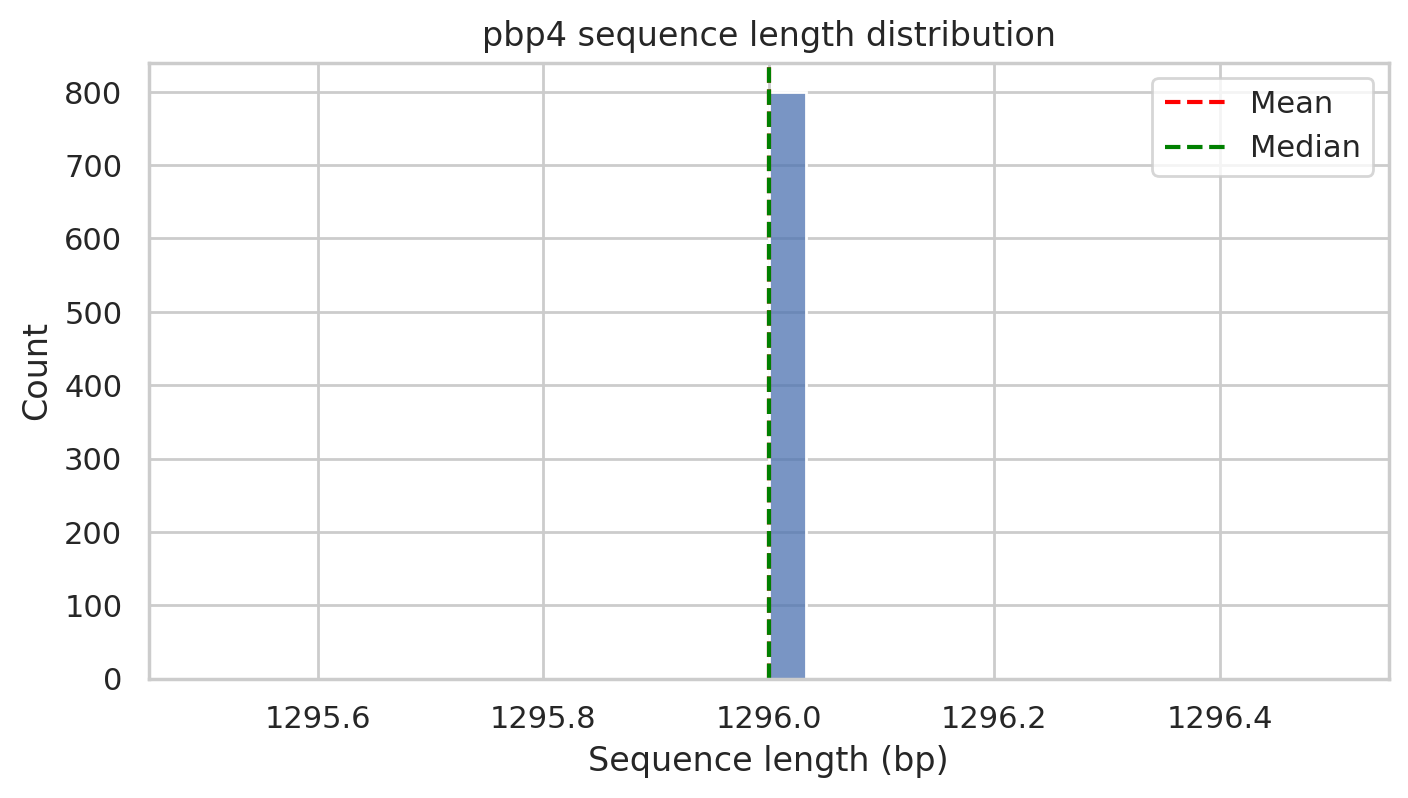

Mean length  : 1296.0
Median length: 1296.0
Training set
  Non-resistant (0): 179
  Resistant     (1): 621
Test set
  Non-resistant (0): 21
  Resistant     (1): 78


In [3]:
# ==============================================================================
# EXPLORATORY DATA ANALYSIS
# ==============================================================================
lengths = [len(s) for s in seq_train]
plt.figure(figsize=(8,4))
sns.histplot(lengths, bins=30)
plt.axvline(np.mean(lengths), color="red", linestyle="--", label="Mean")
plt.axvline(np.median(lengths), color="green", linestyle="--", label="Median")
plt.xlabel("Sequence length (bp)")
plt.ylabel("Count")
plt.title("pbp4 sequence length distribution")
plt.legend()
plt.show()

print(f"Mean length  : {np.mean(lengths):.1f}")
print(f"Median length: {np.median(lengths):.1f}")

def label_summary(y, name):
    print(f"{name}")
    print(f"  Non-resistant (0): {y.count(0)}")
    print(f"  Resistant     (1): {y.count(1)}")

label_summary(y_train, "Training set")
label_summary(y_test,  "Test set")

### 4. DNABERT-2 Preparation

This cell initializes the preprocessing pipeline and loads the tokenizer required for the **DNABERT-2** genomic foundation model.

#### **1. Preprocessing Functions**
* **`clean_dna(seq)`**: Standardizes raw DNA sequences. It forces uppercase and filters out any non-standard characters (like whitespace or ambiguous 'N' bases), keeping only **A, C, G, and T**.
* **`sliding_window(seq)`**: Handles sequences longer than the model's capacity.
    * **Window Size (`510`)**: The chunk size is set to 510 to reserve exactly 2 slots for the special tokens (`[CLS]` and `[SEP]`) needed to reach the model's hard limit of 512 tokens.
    * **Stride (`250`)**:  Creates a 50% overlap between chunks. This ensures that motifs cut off at the edge of one window are preserved in the center of the next.

#### **2. Model Loading**
Initializes the **`zhihan1996/DNABERT-2-117M`** tokenizer.
* *Note:* `trust_remote_code=True` is enabled because DNABERT-2 relies on custom code execution from the Hugging Face hub rather than standard Transformers library classes.

In [4]:
def clean_dna(seq):
    """Prepare DNA sequence for DNABERT-2: uppercase + ACGT only"""
    seq = seq.upper()
    return ''.join(c for c in seq if c in 'ACGT')

def sliding_window(seq, window=510, stride=250):
    if len(seq) < window:
        return []
    return [
        seq[i:i+window]
        for i in range(0, len(seq) - window + 1, stride)
    ]

# Model & Tokenizer
model_name = "zhihan1996/DNABERT-2-117M"

print("Loading DNABERT-2 tokenizer and model...")
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

Loading DNABERT-2 tokenizer and model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

### 5. Gene-Level Train/Val Split (Leakage Prevention)

This cell performs the train/validation split and processes the raw sequences into model-ready fragments.

#### **1. Stratified Split at the Gene Level**
* **Leakage Prevention:**  The split is performed on the **whole genes** (`seq_train`) *before* any fragmentation occurs. This ensures that all fragments derived from a specific gene reside strictly in either the Training set or the Validation set, never both.
* **Stratification (`stratify=y_train`)**: Ensures the ratio of classes (labels) remains consistent between the training and validation sets, preventing class imbalance.

#### **2. Fragment Expansion (`process_genes_to_fragments`)**
* **Logic:** Iterates through the isolated gene lists and applies the `clean_dna` and `sliding_window` functions defined previously.
* **Label Propagation:** Every fragment generated from a gene inherits that gene's original label (e.g., if Gene A is "Positive", all 10 fragments of Gene A are labeled "Positive").
* **Data Expansion:** The print statements at the end will quantify the dataset expansion (e.g., converting 1,000 genes into 5,000+ fragments).

In [5]:
print("Splitting data at gene level...")
train_genes, val_genes, train_y_gene, val_y_gene = train_test_split(
    seq_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

def process_genes_to_fragments(sequences, labels):
    fragments = []
    frag_labels = []
    for seq, label in zip(sequences, labels):
        wins = sliding_window(clean_dna(seq))  # clean once
        for w in wins:
            fragments.append(w)
            frag_labels.append(label)
    return fragments, frag_labels

train_frags, train_frag_labels = process_genes_to_fragments(train_genes, train_y_gene)
val_frags, val_frag_labels = process_genes_to_fragments(val_genes, val_y_gene)

print(f"Training:   {len(train_genes)} genes → {len(train_frags)} fragments")
print(f"Validation: {len(val_genes)} genes → {len(val_frags)} fragments")

Splitting data at gene level...
Training:   640 genes → 2560 fragments
Validation: 160 genes → 640 fragments


### 6. Tokenization (DNABERT-2 Style)

This cell converts the raw DNA text fragments into the numerical tensors required by the model and wraps them into a PyTorch Dataset.

#### **1. BPE Tokenization**
The `tokenizer` converts sequences (e.g., "ATGC...") into integer IDs.
* **No Manual K-mers:** Unlike DNABERT-1, we feed raw DNA strings directly. The tokenizer uses Byte Pair Encoding (BPE) to intelligently group frequent nucleotide patterns into tokens.
* **Padding & Truncation:** * `max_length=512`: The sequence is padded with zeros (if short) or cut off (if long) to ensure a uniform length of 512 tokens.
    * *Note:* Since our sliding window was 510, we fit perfectly within 512, leaving room for the `[CLS]` (start) and `[SEP]` (end) tokens added automatically.
* **`return_tensors="pt"`**: Returns PyTorch tensors directly, saving a manual conversion step.

#### **2. Custom Dataset Class (`DNABertDataset`)**
A standard PyTorch `Dataset` wrapper that:
* Stores the tokenized inputs (`input_ids`, `attention_mask`) and their corresponding labels.
* Implements `__getitem__` to allow the DataLoader to fetch batches of data efficiently during training.

In [6]:
print("Tokenizing fragments (raw DNA → BPE)...")
train_encodings = tokenizer(
    train_frags,
    padding="max_length",
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

val_encodings = tokenizer(
    val_frags,
    padding="max_length",
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

class DNABertDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = DNABertDataset(train_encodings, train_frag_labels)
val_dataset   = DNABertDataset(val_encodings,   val_frag_labels)

Tokenizing fragments (raw DNA → BPE)...


### 7. Model Loading & Class Weights

This cell loads the pre-trained model, calculates weights to balance the classes, and overrides the default training logic to use those weights.

#### **1. Model Initialization**
* **`BertForSequenceClassification`**: We load the base DNABERT-2 model but attach a classification head instead of the default language modeling head.
* **`ignore_mismatched_sizes=True`**: This is required because we are discarding the pre-trained output layer (which likely had thousands of token outputs) and replacing it with a new layer that has exactly **2 outputs** (Positive/Negative).
* **`trust_remote_code=True`**: Essential for DNABERT-2 to load its custom architecture definition.

#### **2. Class Weight Calculation**
* **The Logic:**  We calculate "Inverse Frequency" weights.
    * If Class 0 (Negative) is very common, it gets a **low weight**.
    * If Class 1 (Positive) is rare, it gets a **high weight**.
* **The Goal:** This prevents the model from achieving "high accuracy" by simply guessing the majority class every time. It forces the model to pay more attention to the rare positive examples.

#### **3. Custom `WeightedTrainer`**
* **Why Subclass?** The standard Hugging Face `Trainer` assumes all errors are equal. We create a subclass to override the `compute_loss` function.
* **`CrossEntropyLoss(weight=class_weights)`**: We inject our calculated weights into the loss function. This means the model gets a much larger "penalty" for getting a positive sample wrong than for getting a negative sample wrong.

In [7]:
print("Loading DNABERT-2 model...")
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True,
    trust_remote_code=True
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Class weights
class_counts = np.bincount(train_frag_labels)
class_weights = torch.FloatTensor([
    len(train_frag_labels) / (2.0 * class_counts[0]),
    len(train_frag_labels) / (2.0 * class_counts[1])
]).to(device)

print(f"Class weights: {class_weights.cpu().numpy()}")

# Custom Trainer with weighted loss
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

Loading DNABERT-2 model...


config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/468M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/468M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.embeddings.position_embeddings.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.1.attention.self.key.bias', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.1.attention.self.query.bias', 'bert.encoder.layer.1.attention.self.query.weight', 'bert.encoder.layer.1.at

Class weights: [2.2377622 0.6438632]


### 8. Training Setup

This cell configures the hyperparameters, evaluation metrics, and executes the fine-tuning loop.

#### **1. Training Arguments (Hyperparameters)**
* **Memory Management:**
    * **`per_device_train_batch_size=8`**: Kept low to fit in GPU memory.
    * **`gradient_accumulation_steps=2`**:  We wait for 2 small batches before updating the model weights. This simulates a larger "effective batch size" of 16 (8 * 2) without crashing the GPU.
    * **`gradient_checkpointing=True`**: A critical setting for BERT models. It trades a small amount of computation speed to save massive amounts of memory, allowing larger batch sizes.
    * **`fp16=...`**: Uses Mixed Precision (16-bit floats) if a GPU is available, speeding up training by ~2x and reducing memory usage.
* **Optimization:**
    * **`learning_rate=2e-5`**: A standard low learning rate for fine-tuning pre-trained models.
    * **`metric_for_best_model="roc_auc"`**: We save the best model based on its ability to distinguish classes (AUC), not just raw accuracy.

#### **2. Metric Computation (`compute_metrics`)**
This function runs at the end of every epoch to grade the model.
* **Why not just Accuracy?** Accuracy can be misleading in imbalanced data (e.g., predicting "All Negative" might yield 90% accuracy but is useless).
* **Key Metrics:**
    * **F1 Score:** The harmonic mean of Precision and Recall.
    * **ROC AUC:**  Measures the model's ability to rank positive samples higher than negative ones across all thresholds. Ideally close to 1.0; 0.5 is random guessing.

#### **3. Execution**
Initializes our custom `WeightedTrainer` and calls `.train()` to begin the process.

In [8]:
training_args = TrainingArguments(
    output_dir="./dnabert2_pbp4",
    num_train_epochs=8,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    gradient_checkpointing=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    logging_steps=20,
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = F.softmax(torch.tensor(logits), dim=-1).numpy()
    predictions = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)

    try:
        roc_auc = roc_auc_score(labels, probs[:, 1])
    except:
        roc_auc = 0.5

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc
    }

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("Starting fine-tuning with DNABERT-2...")
trainer.train()

Starting fine-tuning with DNABERT-2...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
1,0.819400,0.687238,0.501563,0.551336,0.911628,0.395161,0.788194
2,0.411700,0.347438,0.879687,0.920042,0.948608,0.893145,0.919397
3,0.395000,0.339195,0.882812,0.922601,0.945032,0.901210,0.931410
4,0.459300,0.365453,0.879687,0.919033,0.960440,0.881048,0.931648
5,0.412100,0.330689,0.882812,0.921301,0.960613,0.885081,0.934644
6,0.245100,0.392426,0.887500,0.927273,0.929150,0.925403,0.934714
7,0.376000,0.358602,0.892188,0.929376,0.943867,0.915323,0.932768
8,0.255100,0.336007,0.887500,0.925000,0.956897,0.895161,0.932978


TrainOutput(global_step=1280, training_loss=0.43165813125669955, metrics={'train_runtime': 750.0192, 'train_samples_per_second': 27.306, 'train_steps_per_second': 1.707, 'total_flos': 5388514413772800.0, 'train_loss': 0.43165813125669955, 'epoch': 8.0})

### 9. Gene-Level Evaluation (Aggregation)

This cell bridges the gap between our fragment-based training and the gene-level biological reality.

#### **1. The Aggregation Problem**
We trained the model on 510bp chunks. A real gene might be 2,000bp long (4 chunks).
* If Chunk 1 says "Negative" (10%)
* And Chunk 2 says "Positive" (99%)
* And Chunk 3 says "Negative" (10%)
* **Is the gene Positive?** YES. The presence of the resistance mechanism in Chunk 2 makes the whole gene resistant.

#### **2. The Solution: Max Pooling**

We use **Max Pooling** logic (`np.max(resist_probs)`):
1.  **Fragment:** We chop the validation gene into fragments on the fly.
2.  **Inference:** We get a probability score for *every* fragment.
3.  **Aggregate:** We take the **highest** probability score observed across all fragments as the score for the whole gene.

* *Biologically:* This assumes that if the model detects a strong "resistance signal" in any part of the sequence, that signal defines the gene's classification.

#### **3. Execution Flow**
* **`model.eval()`**: Switches the model to evaluation mode (disables Dropout, etc., for deterministic results).
* **`torch.no_grad()`**: Disables gradient calculation to save memory and speed up inference, since we aren't training anymore.

In [9]:
# ==============================================================================
# GENE-LEVEL EVALUATION (on validation genes)
# ==============================================================================
model.eval()

print(f"\nEvaluating {len(val_genes)} validation genes using MAX pooling...")

gene_predictions = []
gene_true_labels = []

for i, (sequence, label) in enumerate(zip(val_genes, val_y_gene)):
    fragments = sliding_window(clean_dna(sequence))
    if not fragments:
        continue

    inputs = tokenizer(
        fragments,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        resist_probs = probs[:, 1].cpu().numpy()

    # MAX POOLING - take the highest resistance probability
    gene_score = np.max(resist_probs) if len(resist_probs) > 0 else 0.0

    gene_predictions.append(gene_score)
    gene_true_labels.append(label)

    if i % 20 == 0:
        print(f"Processed {i}/{len(val_genes)}...", end="\r")

print("\nEvaluation complete.")


Evaluating 160 validation genes using MAX pooling...

Evaluation complete.


### 10. Final Metrics & Visualizations

This cell computes the definitive performance metrics for the model at the gene level and visualizes the results.

#### **1. Metric Calculations**
* **Classification Report:** Provides granular metrics for both classes:
    * **Precision:** If the model says "Resistant", how often is it right? (Important to avoid false alarms).
    * **Recall (Sensitivity):** Of all the actual Resistant genes, how many did we catch? (Crucial for screening).
* **ROC AUC Score:** The single most important number. It tells us how well the model separates Susceptible genes from Resistant genes across all probability thresholds.
    * `0.5` = Random guessing.
    * `1.0` = Perfect separation.

#### **2. Visualizations**
* **ROC Curve (Left Plot):** *  
    * Shows the trade-off between catching true positives (Y-axis) and allowing false alarms (X-axis).
    * A curve hugging the **top-left corner** is ideal. A diagonal line means the model failed to learn.
* **Confusion Matrix (Right Plot):** *
    * A heatmap comparing Actual vs. Predicted labels.
    * **Diagonal cells (Top-Left & Bottom-Right):** Correct predictions.
    * **Off-diagonal:** Errors (False Positives and False Negatives). This helps you see *how* the model is failing (e.g., is it missing resistance genes, or flagging everything as resistant?).


FINAL GENE-LEVEL METRICS (Validation set) - MAX POOLING
              precision    recall  f1-score   support

 Susceptible       0.80      0.56      0.66        36
   Resistant       0.88      0.96      0.92       124

    accuracy                           0.87       160
   macro avg       0.84      0.76      0.79       160
weighted avg       0.86      0.87      0.86       160

ROC AUC: 0.9456


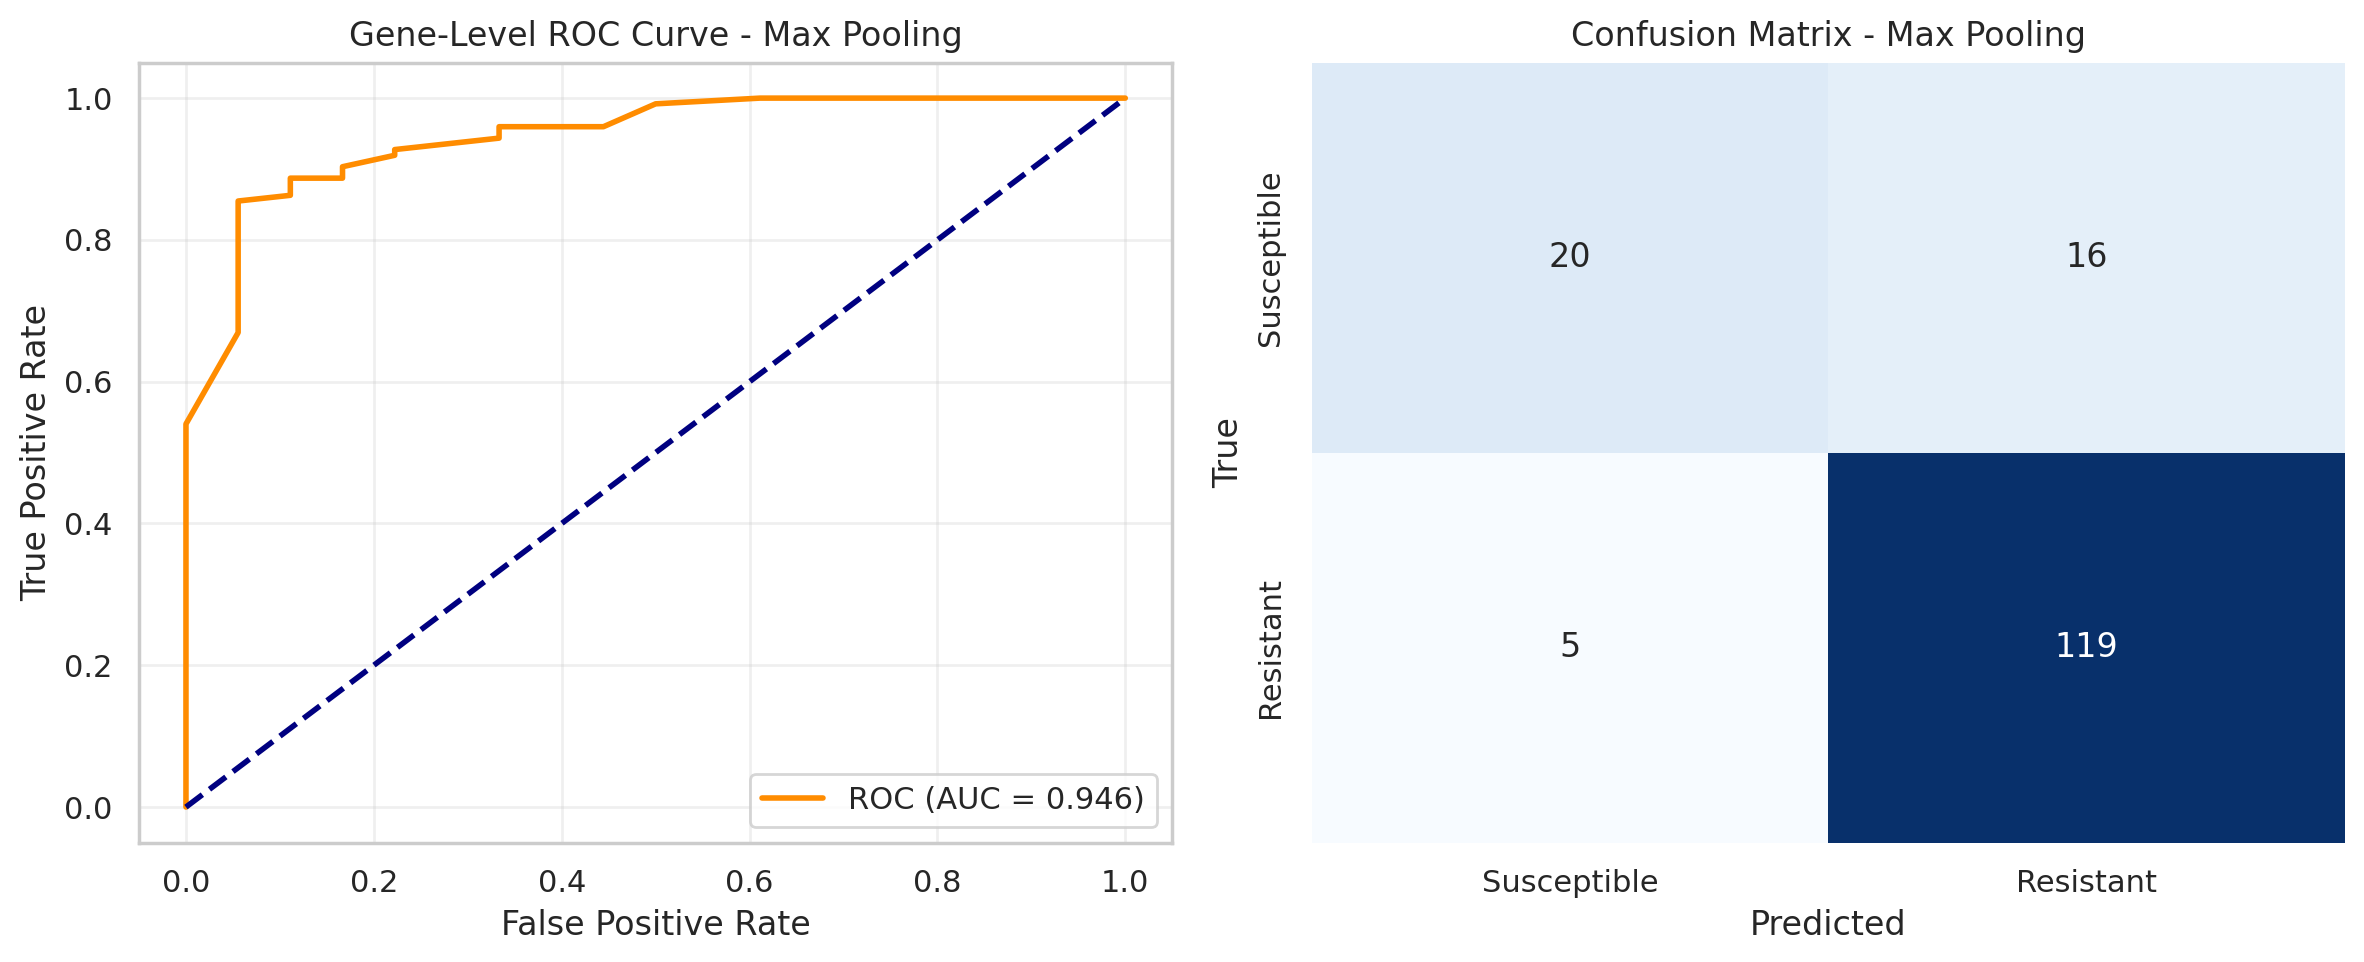

In [10]:
# ==============================================================================
# 10. FINAL METRICS & VISUALIZATIONS
# ==============================================================================
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score

y_true = np.array(gene_true_labels)
y_scores = np.array(gene_predictions)
y_pred = (y_scores >= 0.5).astype(int)

print("\n" + "="*60)
print("FINAL GENE-LEVEL METRICS (Validation set) - MAX POOLING")
print("="*60)
print(classification_report(y_true, y_pred, target_names=['Susceptible', 'Resistant']))

roc_auc = roc_auc_score(y_true, y_scores)
print(f"ROC AUC: {roc_auc:.4f}")

# Plots
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gene-Level ROC Curve - Max Pooling')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# Confusion Matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Susceptible', 'Resistant'],
            yticklabels=['Susceptible', 'Resistant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Max Pooling')

plt.tight_layout()
plt.show()

### 11. Final Evaluation on Held-Out Test Set (Official Results)

This cell performs the definitive performance assessment on the unseen Test Set (99 samples) to determine the model's true generalization capability.

#### **1. Inference on Unseen Data**
* **The Process:** We repeat the exact same inference pipeline used for validation:
    1.  **Fragment:** Slice the test gene into 510bp chunks.
    2.  **Predict:** Run the model on each chunk.
    3.  **Aggregate (Max Pooling):** `np.max(resist_probs)` assigns the highest fragment score as the score for the entire gene.
* **Why Separate this from Validation?** The Validation set was used to guide training (e.g., "stop at epoch 4"). If we reported results on that set, they would be biased. The Test Set provides an unbiased estimate of real-world accuracy.

#### **2. Official Metrics**
* **`classification_report`**: Breaks down Precision (trustworthiness) and Recall (sensitivity) for both Susceptible and Resistant classes on these new 99 samples.
* **`ROC AUC`**: The headline metric.
    * **High Test AUC (e.g., >0.85):** The model generalizes well and has learned robust biological features.
    * **Low Test AUC (vs High Val AUC):** Indicates **overfitting**—the model memorized the training/validation data but fails on new genes.

In [11]:
print("\n" + "="*70)
print("FINAL EVALUATION ON HELD-OUT TEST SET (99 samples)")
print("="*70)

gene_predictions_test = []
gene_true_labels_test = []

model.eval()

for i, (sequence, label) in enumerate(zip(seq_test, y_test)):
    fragments = sliding_window(clean_dna(sequence))
    if not fragments:
        continue

    inputs = tokenizer(
        fragments,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        resist_probs = probs[:, 1].cpu().numpy()

    # Use the pooling strategy you chose (here: max pooling)
    gene_score = np.max(resist_probs) if len(resist_probs) > 0 else 0.0

    gene_predictions_test.append(gene_score)
    gene_true_labels_test.append(label)

    if i % 20 == 0:
        print(f"Processed test sample {i}/{len(seq_test)}...", end="\r")

print("\nTest evaluation complete.")

# Compute metrics
y_true_test = np.array(gene_true_labels_test)
y_scores_test = np.array(gene_predictions_test)
y_pred_test = (y_scores_test >= 0.5).astype(int)  # or your chosen threshold

print(classification_report(y_true_test, y_pred_test, target_names=['Susceptible', 'Resistant']))
print(f"ROC AUC: {roc_auc_score(y_true_test, y_scores_test):.4f}")

# You can also plot ROC and confusion matrix for the test set


FINAL EVALUATION ON HELD-OUT TEST SET (99 samples)

Test evaluation complete.
              precision    recall  f1-score   support

 Susceptible       0.94      0.81      0.87        21
   Resistant       0.95      0.99      0.97        78

    accuracy                           0.95        99
   macro avg       0.95      0.90      0.92        99
weighted avg       0.95      0.95      0.95        99

ROC AUC: 0.9887


### 12. CNN Baseline: Architecture Definition

To benchmark our DNABERT-2 model, we define a lightweight **1D Convolutional Neural Network (CNN)**.

#### **Why a CNN?**
While Transformers pay attention to global context, CNNs are excellent at detecting **local motifs** (short, fixed patterns like binding sites or promoters) regardless of where they appear in the sequence.

#### **Architecture Breakdown**
* **1. Embedding Layer:** Converts token IDs into dense vectors, similar to DNABERT, but trained from scratch.
* **2. 1D Convolution (`nn.Conv1d`):**
    * Acts like a sliding window scanner.
    * **`kernel_size`**: The width of the scanner. A kernel size of 9 means it looks at 9 base pairs at a time.
    * **`num_filters`**: The number of different "scanners." If we have 256 filters, the model learns to recognize 256 different DNA motifs simultaneously.
* **3. Global Max Pooling:**
    * **Logic:** We don't care *where* a resistance mutation appears (start, middle, or end of the gene), only *if* it appears.
    * Max Pooling grabs the strongest signal found by each filter across the entire sequence and discards the position information.

In [12]:
class GenomicCNNConfig(PretrainedConfig):
    """Configuration class for GenomicCNN model."""
    model_type = "genomic_cnn"

    def __init__(
        self,
        vocab_size=4096,
        embed_dim=128,
        num_filters=128,
        kernel_size=6,
        num_labels=2,
        dropout_rate=0.1,
        padding_idx=0,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.num_labels = num_labels
        self.dropout_rate = dropout_rate
        self.padding_idx = padding_idx

### **Model Architecture: GenomicCNN**

The following cell defines `GenomicCNN`, a custom **1D Convolutional Neural Network** designed for classifying genomic sequences. It inherits from the Hugging Face `PreTrainedModel` class, ensuring full compatibility with the `Trainer` API.

**Key Architectural Steps:**
1.  **Embedding:** Converts discrete DNA tokens into dense vectors.
2.  **1D Convolution (`Conv1d`):** Slides filters across the sequence to detect local motifs (e.g., binding sites). The input is permuted to match PyTorch's channel-first format.
3.  **Global Max Pooling:** Captures the strongest activation for each filter across the entire sequence length.
4.  **Classification:** A final linear layer projects the pooled features to the target labels.

> **Note:** The `forward` method automatically computes `CrossEntropyLoss` if `labels` are provided and checks for global `class_weights` to handle class imbalance.

In [13]:
class GenomicCNN(PreTrainedModel):
    """
    1D Convolutional Neural Network for genomic sequence classification.

    Architecture:
    - Embedding layer for tokenized DNA sequences
    - 1D Convolution to capture local sequence motifs
    - Global max pooling to identify strongest features
    - Classification head
    """
    config_class = GenomicCNNConfig

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels


        self.embedding = nn.Embedding(
            config.vocab_size,
            config.embed_dim,
            padding_idx=config.padding_idx
        )


        self.conv1 = nn.Conv1d(
            in_channels=config.embed_dim,
            out_channels=config.num_filters,
            kernel_size=config.kernel_size
        )
        self.relu = nn.ReLU()


        self.pool = nn.AdaptiveMaxPool1d(1)


        self.dropout = nn.Dropout(config.dropout_rate)
        self.classifier = nn.Linear(config.num_filters, config.num_labels)


        self.post_init()

    def forward(self, input_ids, attention_mask=None, labels=None, **kwargs):
        """
        Forward pass through the CNN.

        Args:
            input_ids: Tokenized input sequences [Batch, SeqLen]
            attention_mask: Optional attention mask (not used in CNN)
            labels: Ground truth labels for training

        Returns:
            Sequenit ceClassifierOutput with loss and logits
        """
        # 1. Embed: [Batch, SeqLen] -> [Batch, SeqLen, EmbedDim]
        x = self.embedding(input_ids)

        # 2. Permute for Conv1d: [Batch, EmbedDim, SeqLen]
        x = x.permute(0, 2, 1)

        # 3. Convolve & Pool
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x).squeeze(-1)  # [Batch, NumFilters]

        # 4. Classify
        x = self.dropout(x)
        logits = self.classifier(x)

        # 5. Loss Calculation (Optional, for Trainer)
        loss = None
        if labels is not None:
            # Check if class_weights is defined globally, otherwise use equal weights
            if 'class_weights' in globals() and class_weights is not None:
                loss_fct = nn.CrossEntropyLoss(weight=class_weights)
            else:
                loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(loss=loss, logits=logits)

### **Model Configuration & Initialization**

In this step, we instantiate the `GenomicCNN` using a specific configuration object. This decouples the hyperparameters from the model architecture, making it easier to tune.

**Key Hyperparameters:**
* **`embed_dim` (256):** The size of the dense vector representation for each nucleotide.
* **`kernel_size` (9):** The window size of the convolution. A size of 9 is chosen to approximate the length of common biological motifs (transcription factor binding sites often span 6-12bp).
* **`num_filters` (256):** The number of different motifs the model attempts to learn and detect.

The model is immediately moved to the active `device` (GPU/CPU) to ensure subsequent operations are hardware-accelerated.

In [14]:
# Create configuration
config = GenomicCNNConfig(
    vocab_size=len(tokenizer),  # Use your tokenizer's vocab size
    embed_dim=256,               # Standard dimension for DNA embeddings
    num_filters=256,             # Capacity to learn many motifs
    kernel_size=9,               # Look at ~9bp context at once
    num_labels=2,                # Binary classification
    dropout_rate=0.1
)

# Initialize model
cnn_model = GenomicCNN(config).to(device)

print(f"✓ Initialized CNN with {sum(p.numel() for p in cnn_model.parameters()):,} parameters")
print(f"  - Embedding dimension: {config.embed_dim}")
print(f"  - Number of filters: {config.num_filters}")
print(f"  - Kernel size: {config.kernel_size}")





✓ Initialized CNN with 1,639,170 parameters
  - Embedding dimension: 256
  - Number of filters: 256
  - Kernel size: 9


### **Step 4: Training Configuration & Execution**

We configure the training loop using `TrainingArguments` specifically tuned for a CNN architecture. Unlike Transformers, CNNs are generally lighter and can handle different hyperparameters.

**CNN-Specific Adjustments:**
* **Higher Learning Rate (`1e-3`):** CNNs often benefit from a more aggressive learning rate compared to Transformers (which usually require `1e-5` to `5e-5`) to converge efficiently.
* **Larger Batch Size:** Due to the lower memory footprint of the CNN model, we can increase the `per_device_train_batch_size` to 16 (or higher depending on VRAM), providing more stable gradient estimates.

**Process:**
1.  **Arguments:** Define checkpoints, logging, and evaluation strategies (saving the best model based on F1 score).
2.  **Trainer:** Initialize the `WeightedTrainer` (reused from previous steps) to handle the custom loss weighing for class imbalance.
3.  **Execution:** Launch the training loop.

In [15]:
cnn_training_args = TrainingArguments(
    output_dir="./cnn_baseline_pbp4",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=1e-3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_steps=50,
    report_to="none",
    save_total_limit=2
)

cnn_trainer = WeightedTrainer(
    model=cnn_model,
    args=cnn_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("\n🚀 Starting CNN Baseline Training...")
cnn_trainer.train()
print("✓ Training completed!")


🚀 Starting CNN Baseline Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Roc Auc
1,0.354900,0.332291,0.845313,0.892508,0.967059,0.828629,0.935064
2,0.270500,0.309294,0.890625,0.927386,0.955128,0.901210,0.943618
3,0.290000,0.307069,0.864062,0.906351,0.972286,0.848790,0.947525
4,0.275400,0.282587,0.871875,0.912580,0.968326,0.862903,0.954413
5,0.272200,0.266894,0.893750,0.928870,0.965217,0.895161,0.959516
6,0.241500,0.271122,0.896875,0.931535,0.959402,0.905242,0.959187
7,0.216800,0.265877,0.900000,0.933472,0.963519,0.905242,0.961820
8,0.254200,0.252988,0.876563,0.916402,0.964365,0.872984,0.961386
9,0.215800,0.251340,0.901563,0.934443,0.965591,0.905242,0.962114
10,0.227100,0.251816,0.898438,0.931937,0.969499,0.897177,0.961281


/usr/local/lib/python3.12/dist-packages/transformers/trainer.py:4380: UserWarning: mtime may not be reliable on this filesystem, falling back to numerical ordering
  warnings.warn("mtime may not be reliable on this filesystem, falling back to numerical ordering")


✓ Training completed!


### **Evaluation & Gene-Level Aggregation**

This cell evaluates the trained CNN on the held-out test set (N=99 genes).

**The Challenge:**
Whole genes are often longer than the model's maximum context window (512 tokens).

**The Solution: Fragment & Aggregate**
1.  **Fragment:** We slice each gene into overlapping windows using the same `sliding_window` function used during data preprocessing.
2.  **Inference:** The model predicts the probability of resistance for *each individual fragment*.
3.  **Aggregation (Max Pooling):** We assign a final "Resistance Score" to the gene by taking the **maximum** probability observed across all its fragments.
    * *Logic:* If the model detects a strong resistance motif in *any* part of the sequence (e.g., a specific active site), the whole gene is flagged as resistant.

> **Note:** We strictly use the same test genes (`seq_test`) as the previous DNABERT experiments to ensure a fair, apples-to-apples comparison.

In [16]:
print("\n📊 Evaluating CNN on Test Set (N=99)...")
cnn_model.eval()
cnn_preds = []

# Loop over the SAME test genes used for DNABERT
for i, (sequence, label) in enumerate(zip(seq_test, y_test)):
    # Clean & Fragment (using your existing functions)
    fragments = sliding_window(clean_dna(sequence))
    if not fragments:
        cnn_preds.append(0.0)
        continue

    # Tokenize
    inputs = tokenizer(
        fragments,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    # Inference
    with torch.no_grad():
        outputs = cnn_model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        resist_probs = probs[:, 1].cpu().numpy()

    # Max Pooling Aggregation
    gene_score = np.max(resist_probs)
    cnn_preds.append(gene_score)

    # Progress indicator
    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{len(seq_test)} genes...")


📊 Evaluating CNN on Test Set (N=99)...
  Processed 10/99 genes...
  Processed 20/99 genes...
  Processed 30/99 genes...
  Processed 40/99 genes...
  Processed 50/99 genes...
  Processed 60/99 genes...
  Processed 70/99 genes...
  Processed 80/99 genes...
  Processed 90/99 genes...


In [17]:
# ==============================================================================
# METRICS
# ==============================================================================
y_cnn_pred = (np.array(cnn_preds) >= 0.5).astype(int)

print("\n" + "="*60)
print("CNN BASELINE RESULTS")
print("="*60)
print(classification_report(
    y_test,
    y_cnn_pred,
    target_names=['Susceptible', 'Resistant'],
    digits=4
))
print(f"\nCNN Accuracy: {accuracy_score(y_test, y_cnn_pred):.4f}")
print(f"CNN ROC AUC:  {roc_auc_score(y_test, cnn_preds):.4f}")
print("="*60)


CNN BASELINE RESULTS
              precision    recall  f1-score   support

 Susceptible     0.7826    0.8571    0.8182        21
   Resistant     0.9605    0.9359    0.9481        78

    accuracy                         0.9192        99
   macro avg     0.8716    0.8965    0.8831        99
weighted avg     0.9228    0.9192    0.9205        99


CNN Accuracy: 0.9192
CNN ROC AUC:  0.9869
